# Modeling Kanwal (2007)

## Contents of readme

Each file in this dataset corresponds to one of the four experimental conditions described in the paper: Combined condition (data_dyad_all_R_dem.csv), Accuracy condition (data_partner_only_all_R_dem.csv), Time condition (data_time_only_R_dem), and Neither condition (data_min_R_dem.csv).

Descriptions of the column headings are as follows:

* **pairnum** - the ID number of the pair
* **IP** - IP address of individual participant
* **timestamp** - time of data collection
* **counterbalance** - ID number of counterbalance condition (1, 2, 3, or 4)
* **code** - completion code entered by participant
* **trial** - director trial number (up to 32 in Combined & Accuracy conditions, up to 64 in Time and Neither conditions)
* **display** - 0/1 = frequent object displayed to director, 2/3 = infrequent object displayed
* **label** - label chosen by director (zop = short label)
* **button.side** - placement of button corresponding to the chosen label (R or L)
* **workerID** - turk worker ID of individual participant
* **age** - age of participant
* **gender** - gender of participant
* **L1** - participant's native language(s)
* **L2** - participant's other spoken language(s)
* **explanation** - explanation given by participant of their strategy during the director trials, from the exit survey

In [1]:
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdb
import seaborn as sns

%matplotlib inline 

### Read data

In [2]:
def process_line(l):
    return list(map(lambda x: x.strip(), l.split(', ')))

def file2df(f_path, condition):
    data = []
    with open(f_path, 'r') as f:
        header = process_line(f.readline())
        for l in f.readlines():
            if l == '\n':
                continue
            curr_line = process_line(l)
            data.append({hdr: d for hdr, d in zip(header, curr_line)})

    df = pd.DataFrame(data)
    df['condition'] = condition
    return df

In [3]:
f_combined_path = "kanwal-jasmeen-2017-data/data_dyad_all_R_dem.csv"
f_accuracy_path = "kanwal-jasmeen-2017-data/data_partner_only_all_R_dem.csv"
f_time_path =     "kanwal-jasmeen-2017-data/data_time_only_R_dem.csv"
f_neither_path =  "kanwal-jasmeen-2017-data/data_min_R_dem.csv"

df_combined = file2df(f_combined_path, 'combined')
df_accuracy = file2df(f_accuracy_path, 'accuracy')
df_time =     file2df(f_time_path, 'time')
df_neither =  file2df(f_neither_path, 'neither')

df_agg = df_combined.append(df_accuracy.append(df_time.append(df_neither)))
df_agg['trial'] = df_agg['trial'].apply(lambda x: int(x))
df_agg['display'] = df_agg['display'].apply(lambda x: int(x))

*minor preprocessing*

* code for short vs long name

In [4]:
def get_result(x, typ='infrequent'):
    if typ == 'frequent':
        return x['display'] <= 1 and x['label_type'] == 0
    else:
        return x['display'] > 1 and x['label_type'] == 0

df_agg['label_type'] = df_agg['label'].apply(lambda x: 'short' if x == 'zop' else 'long')
df_agg['display_type'] = df_agg['display'].apply(lambda x: 'frequent' if x < 2 else 'infrequent')
# df_agg['short_infrequent'] = df_agg.apply(lambda x: get_result(x, 'infrequent'), axis=1) 
# df_agg['short_frequent'] = df_agg.apply(lambda x: get_result(x, 'frequent'), axis=1) 

In [5]:
df_agg.head()

,IP,L1,L2,age,button.side,code,condition,counterbalance,display,explanation,gender,label,pairnum,timestamp,trial,workerID,label_type,display_type
0,67.85.42.18,"""English""","""{}""",29,R,JK03850S,combined,1,0,"""We seemed to agree on just using zop for the ...",Male,zop,1,14:16 18/11/2015,1,ARVXIBUCA8WDZ,short,frequent
1,67.85.42.18,"""English""","""{}""",29,R,JK03850S,combined,1,3,"""We seemed to agree on just using zop for the ...",Male,zopudon,1,14:16 18/11/2015,2,ARVXIBUCA8WDZ,long,infrequent
2,67.85.42.18,"""English""","""{}""",29,R,JK03850S,combined,1,0,"""We seemed to agree on just using zop for the ...",Male,zop,1,14:16 18/11/2015,3,ARVXIBUCA8WDZ,short,frequent
3,67.85.42.18,"""English""","""{}""",29,L,JK03850S,combined,1,0,"""We seemed to agree on just using zop for the ...",Male,zopekil,1,14:16 18/11/2015,4,ARVXIBUCA8WDZ,long,frequent
4,67.85.42.18,"""English""","""{}""",29,L,JK03850S,combined,1,2,"""We seemed to agree on just using zop for the ...",Male,zopudon,1,14:16 18/11/2015,5,ARVXIBUCA8WDZ,long,infrequent


### View data

In [6]:
def append_new_rows(x, missing_display_types, missing_label_types):
    n = len(missing_display_types)
    new_df = pd.DataFrame({
        'IP':           np.repeat(set(x['IP']).pop(), n),
        'condition':    np.repeat(set(x['condition']).pop(), n),
        'display_type': missing_display_types,
        'label_type':   missing_label_types,
        'cnt':          np.repeat(0, n)
    })
    x = x \
        .append(new_df) \
        .reset_index()
    return x

def fill_missing_rows(x):
    all_combns = set([
        ('frequent', 'long'), 
        ('infrequent', 'short'), 
        ('frequent', 'short'), 
        ('infrequent', 'long')])

    available_items = set(list(zip(x['display_type'], x['label_type'])))
    missing_items = all_combns - available_items
    missing_display_types = [d for (d, l) in missing_items]
    missing_label_types = [l for (d, l) in missing_items]
    x = append_new_rows(x, missing_display_types, missing_label_types)
    return x
    
def label_props(x):
    x['prop'] = x['cnt'] / sum(x['cnt'])
    return x


In [7]:
df_agg_fig3 = df_agg \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()

In [8]:
df_agg_fig3.head()

display_type,IP,condition,frequent,infrequent
0,100.10.40.83,combined,1.000000,0.0
1,100.2.122.157,combined,0.958333,0.0
2,104.11.62.66,accuracy,0.000000,0.0
3,104.174.222.43,combined,0.000000,0.5
4,104.175.214.163,accuracy,0.000000,0.0


### Reproducing fig 3

Note that this analysis looks slightly different likely because they only used data from the **second half of testing trials!**

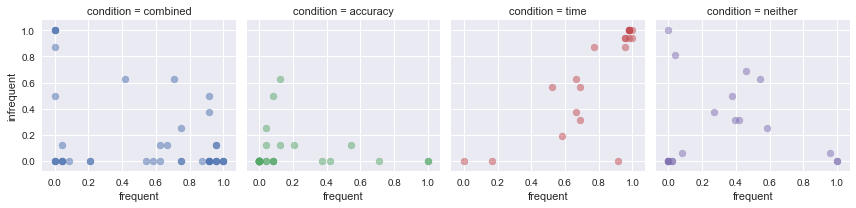

In [11]:
p1 = sns.FacetGrid(col='condition', hue='condition', data=df_agg_fig3)
p1 = p1.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

In [12]:
second_half_filter = \
    (df_agg['trial'] >= 16) & ((df_agg['condition'] == 'combined') | (df_agg['condition'] == 'accuracy')) | \
    (df_agg['trial'] >= 32) & ((df_agg['condition'] == 'time') | (df_agg['condition'] == 'neither'))

#### Reproducing Fig3 - only using second half data...

Plot still looks different

In [13]:
df_fig3_second_half = df_agg[second_half_filter] \
    .groupby(['IP', 'condition', 'display_type', 'label_type']) \
    .count()['L1'] \
    .reset_index() \
    .rename(columns={'L1':'cnt'}) \
    .groupby(['IP', 'condition']) \
    .apply(fill_missing_rows) \
    .set_index(['IP']) \
    .reset_index() \
    .drop(columns=['index']) \
    .groupby(['IP', 'condition', 'display_type']) \
    .apply(label_props) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .pivot_table(values='prop', index=['IP', 'condition'], columns=['display_type']) \
    .reset_index()

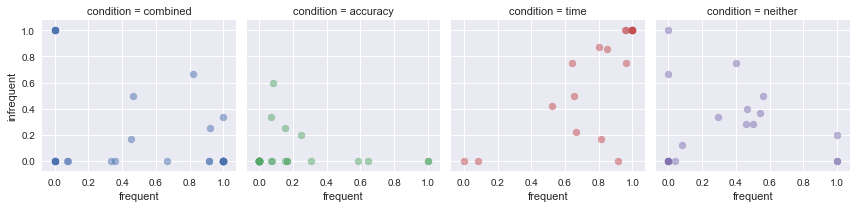

In [14]:
p2 = sns.FacetGrid(col='condition', hue='condition', data=df_fig3_second_half)
p2 = p2.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

## Figure 4

In [15]:
# forms
f_zop = 0.75
f_zopudon = 0.0
f_zopekil = 0.25

# meanings
m_zopudon = 0.75
m_zopekil = 0.25

# p_fm
p_zop_zopudon = 0.75
p_zop_zopekil = 0
p_zopekil_zopekil = 0.25
p_zopudon_zopudon = 0
p_zopekil_zopudon = 0
p_zopudon_zopekil = 0

In [16]:
def MI(p_x, p_y, p_xy):
    if p_x == 0 or p_y == 0 or p_xy == 0:
        return 0
    return p_xy * np.log2(p_xy / (p_x * p_y))

In [17]:
distr = [(f_zop, m_zopudon, p_zop_zopudon),
         (f_zop, m_zopekil, p_zop_zopekil), 
         (f_zopekil, m_zopekil, p_zopekil_zopekil),
         (f_zopudon, m_zopudon, p_zopudon_zopudon),
         (f_zopekil, m_zopudon, p_zopekil_zopudon),
         (f_zopudon, m_zopekil, p_zopudon_zopekil)]

In [18]:
res = [MI(p_x, p_y, p_xy) for (p_x, p_y, p_xy) in distr]
np.sum(res)

0.81127812445913283

# Modeling data

### Combined condition

Data for fitting hyperparams

In [19]:
data = df_agg_fig3 \
    .query('condition=="accuracy"') \
    .to_dict(orient='records')

In [20]:
newD = []
for d in data:
    newD.append({
        'IP': d['IP'],
        'condition': d['condition'],
        'frequent': round(d['frequent'], 2),
        'infrequent': round(d['infrequent'], 2)
    })

## Model output

#### Combination

In [65]:
f_combination = 'combination.json'
f_accuracy = 'accuracy.json'
f_time = 'time.json'
f_other = 'other.json'
df_synthetic = pd.read_json(f_accuracy, orient='records') \
    .append([pd.read_json(f_time, orient='records'), 
             pd.read_json(f_combination, orient='records'),
             pd.read_json(f_other, orient='records')])

In [66]:
df_synthetic = df_synthetic.rename(columns={'trialType':'display_type', 'participantNum':'IP'})
df_synthetic['label_type'] = ['short' if u == 'zop' else 'long' for u in df_synthetic['utterance']]

In [67]:
def normer(x):
    x['prop'] = x['cnt'] / np.sum(x['cnt'])
    return x

def get_label_type(x):
    pdb.set_trace()
    x['label_type'] = 'short' if x['utterance'] == 'zop' else 'long'
    return x
    

df_props = df_synthetic \
    .groupby(['condition', 'IP', 'display_type', 'label_type']) \
    .count()[['trialNum']] \
    .rename(columns={'trialNum': 'cnt'}) \
    .reset_index() \
    .groupby(['condition', 'IP']) \
    .apply(fill_missing_rows) \
    .drop(columns='index') \
    .set_index(['IP']) \
    .reset_index() \
    .groupby(['condition', 'IP', 'display_type']) \
    .apply(normer) \
    .drop(columns=['cnt']) \
    .query('label_type == "short"') \
    .reset_index() \
    .drop(columns='index') \
    .pivot_table(values='prop', index=['condition', 'IP'], columns=['display_type']) \
    .reset_index()


In [68]:
# p = sns.lmplot(x='frequent', y='infrequent', hue='condition',
#                 fit_reg=False, y_jitter=0.1,
#                 scatter_kws={'alpha':0.5}, data=df_props)
# plt.xlim(0, 1)
# plt.ylim(0, 1)

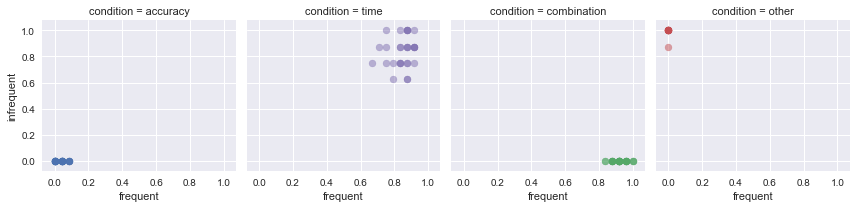

In [69]:
p3 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combination', 'other'], data=df_props)
p3 = p3.map(plt.scatter, "frequent", "infrequent", alpha=0.5)

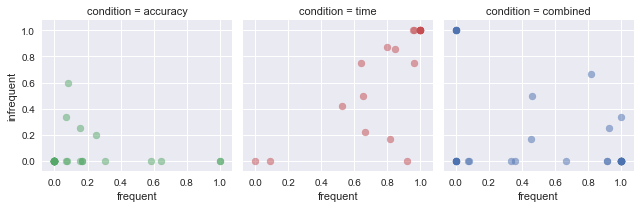

In [70]:
curr_df = df_fig3_second_half[df_fig3_second_half['condition'].isin(['time', 'accuracy', 'combined'])]
p2 = sns.FacetGrid(col='condition', hue='condition', col_order=['accuracy', 'time', 'combined'], data=curr_df)
p2 = p2.map(plt.scatter, "frequent", "infrequent", alpha=0.5)